In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import math
from sklearn.metrics import f1_score

#Info : 552 subjects, 21 waves, 8378 rows
df = pd.read_csv('data/speed_dating_data.csv', encoding = "ISO-8859-1")


In [164]:
df.shape

(8378, 195)

In [35]:
data2 = pd.concat([df.iloc[:,0], #ID
                  df.iloc[:,2], #gender
                  df.iloc[:,5],
                  df.iloc[:,9:12], #order of date
                  #df.iloc[:, 11:12], #partner's id
                  df.iloc[:, 12:13], #match, 
                  df.iloc[:,13:17], #int_corr, samerace, age of partner, race of partner 
                  df.iloc[:,17:23], #stated preferences
                  #df.iloc[:,23:24], #decision of partner - dec-o
                  df.iloc[:,24:28], #attr_o..fun_o
                  df.iloc[:,28:32],
                  df.iloc[:,24],   # rating by partner for 6 attributes, probability of matching with partner #amb-o has lots of missing values - try eliminating
                  #df.iloc[:,:35], # met, age, field
                  df.iloc[:,39:42],#race, importance of race, importance of religion
                  #df.iloc[:,42:43], #from   (DROPPED ZIPCODE AND INCOME AS THEY HAVE TOO MANY MISSING VALUES)
                  df.iloc[:,45:48], #goal, date, go_out
                  #df.iloc[:,48:50], #career, career_coded
                  df.iloc[:,50:67], #interests
                  #df.iloc[:,67:69], #exphappy, expnum (DROPPED - TOO MANY MISSING VALUES)
                  df.iloc[:,69:74],  #what subject looks for in the opposite sex - 6 attributes
                  df.iloc[:,74:75],  #shar1_1
                  df.iloc[:,81:87], #attr2_1,..shar2_1
                  df.iloc[:,87:92],  #attr3_1.. #91 is amb3_1 (how do you measure up)
                  #df.iloc[:,97:98], #decision of subject - dec
                  df.iloc[:,98:102], #ratings by subject for partner for the 6 attributes. 101 is fun
                  df.iloc[:,102:104], #amb,shar
                  df.iloc[:,104:107]],axis=1) #like, prob, met

data3 = data2.dropna()



In [31]:
def heatmap_plot(auc_tr,auc_cv):
    cm_pred=auc_cv
    depth_values=[1,5,10,20,50]
    estim=[5,10,20]
    cm = pd.DataFrame(auc_cv, index =depth_values, columns = estim)
    #auc_hm=cm.pivot()
    plt.figure(figsize = (5,3))
    sns.heatmap(cm, annot=True)

# Models

### SVM

In [12]:
def svc_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    count=1
    for g in range(-2,2):
        gam=math.pow(10,g)
        for i in range(-2,2):            
            c=math.pow(10,i)
            print(f'{count}. c={c},g={gam} running...')
            rbf_clf=SVC(C=c, kernel='rbf', gamma=gam,probability=True,class_weight='balanced')
            rbf_clf.fit(X_train,y_train)
            #rbf_clf.probability=True
            y_rbf=rbf_clf.predict(X_test)
            #y_coef=rbf_clf.dual_coef_
            trauc=rbf_clf.predict_proba(X_train)[:,1]
            cvauc=rbf_clf.predict_proba(X_test)[:,1]
            #print(roc_auc_score(y_train,trauc))
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count+=1
    #print(count)
    #print(len(tr_auc),len(cv_auc))
    return tr_auc,cv_auc

def plot_svc_train(title_plot,train_auc,cv_auc):
    al=range(0,16)
    plt.plot(al, train_auc, label='Train AUC')
    plt.plot(al, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("AUC")
    plt.title(title_plot)
    plt.show()

def plot_heatmap1(auc_tr,auc_cv):
    cm_pred=auc_cv
    cm = pd.DataFrame(auc_cv, index = [i for i in range(-2,2)],
                  columns = [i for i in range(-2,2)])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)

def test_rbf(X_train,y_train,X_test,y_test,c,gam):
    alph=math.pow(10,c)
    rbf_clf=SVC(C=c, kernel='rbf',gamma=gam,probability=True,class_weight='balanced')
    rbf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rbf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rbf_clf.predict_proba(X_test)[:,1])
    test_auc=auc(test_fpr, test_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rbf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rbf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rbf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc


    

### Random Forest

In [59]:
def RF(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,50]
    count=1
    for dep in depth_values:        
        estim=[5,10,20]
        for n in estim:
            rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep,class_weight = "balanced")
            rf_clf.fit(X_train,y_train)
            y_coef=rf_clf.feature_importances_
            
            y_pred=rf_clf.predict(X_test)
            trauc=rf_clf.predict_proba(X_train)[:,1]
            cvauc=rf_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
            #print(f'{count}. depth={dep},estim={n} cv accuracy={cv_auc}')
    #print(cv_auc)
    return  tr_auc,cv_auc

def test_RandomForest(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep, class_weight = "balanced")
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    test_auc=auc(test_fpr, test_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

### XG Boost

In [14]:
def xgb_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,100]
    count=1
    for dep in depth_values:        
        estim=[5, 50, 100]
        for n in estim:
            xgb_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
            xgb_clf.fit(X_train,y_train)
            #y_coef=rf_clf.feature_importances_
            #print(f'{count}. depth={dep},estim={n} running...')
            y_pred=xgb_clf.predict(X_test)
            trauc=xgb_clf.predict_proba(X_train)[:,1]
            cvauc=xgb_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
    #print(cv_auc)
    return  tr_auc,cv_auc

def test_xgb(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    
    test_auc=auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

## Baseline

#### Baseline model using random Forest classifier

In [144]:
#print(type(data3))
X=data3.drop(['match'],axis=1)
y=data3['match']

X_1, X_test_base, y_1, y_test_base = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_base, X_cv_base, y_train_base, y_cv_base = train_test_split(X_1, y_1, test_size=0.3)

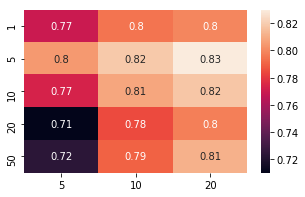

In [145]:
tr_auc, cv_auc=RF(X_train_base,y_train_base,X_cv_base,y_cv_base)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

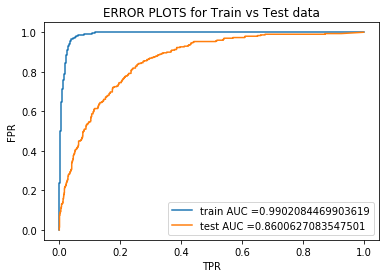

Train confusion matrix
[[2163   93]
 [  17  451]]
Test confusion matrix
[[1247  124]
 [ 140  158]]


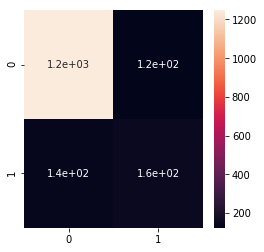

In [146]:
dep=10
n=20
cf_rf_base,auc_rf_base=test_RandomForest(X_train_base,y_train_base,X_test_base,y_test_base,dep,n)

In [159]:
pr_baseline=(cf_rf_base[0,0]/(cf_rf_base[0,1]+cf_rf_base[0,0]))
print(pr_baseline*100)

recall_baseline = (cf_rf_base[0,0]/(cf_rf_base[0,0]+cf_rf_base[1,0]))
print(pr_baseline)

90.95550692924871
0.9095550692924872


## Models after Feature Engineering and feature selection

In [147]:
X=data3[['gender', 'attr_o', 'sinc_o', 'intel_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc', 'fun', 'amb', 'shar', 'prob']]
y=data3['match']

X_1, X_test_fe, y_1, y_test_fe = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_fe, X_cv_fe, y_train_fe, y_cv_fe = train_test_split(X_1, y_1, test_size=0.3)

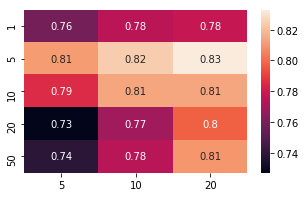

In [148]:
tr_auc, cv_auc=RF(X_train_fe, y_train_fe, X_cv_fe, y_cv_fe)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

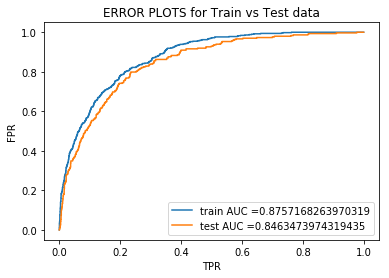

Train confusion matrix
[[1711  507]
 [  98  408]]
Test confusion matrix
[[1049  322]
 [  61  237]]


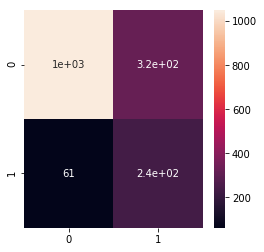

In [150]:
dep=5
n=20
cf_rf_fe,auc_rf_fe=test_RandomForest(X_train_fe, y_train_fe, X_test_fe, y_test_fe,dep,n)

In [160]:
pr_fe=(cf_rf_fe[0,0]/(cf_rf_fe[0,1]+cf_rf_fe[0,0]))
print(pr_fe*100)

recall_fe = (cf_rf_fe[0,0]/(cf_rf_fe[0,0]+cf_rf_fe[1,0]))
print(recall_fe)

76.51349380014588
0.945045045045045


### Using different set of features

In [151]:
X_train=pd.read_csv('data\X_train.csv')
X_train=X_train.iloc[:,0:29]
y_train = pd.read_csv('data\y_train.csv').values.ravel()
X_test = pd.read_csv('data\X_test.csv')
X_test=X_test.iloc[:,0:29]
y_test = pd.read_csv('data\y_test.csv').values.ravel()
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)
#X_train,y_train=smote(X_train,y_train)

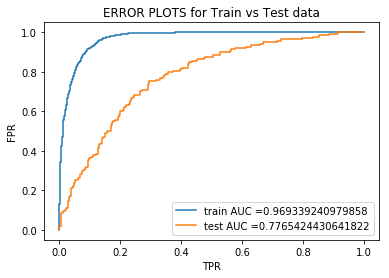

Train confusion matrix
[[4037  379]
 [  85  777]]
Test confusion matrix
[[613  87]
 [ 85  53]]


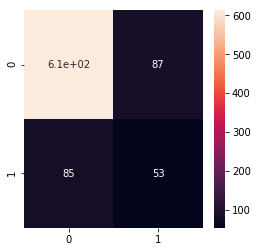

In [152]:
dep=10
n=20
cf_rf_new,auc_rf_new=test_RandomForest(X_train,y_train,X_test,y_test,dep,n)

## Oversampling

In [105]:
def class_counts(classes):
    a = [0,0]
    for c in classes:
        a[int(c)] += 1
        count = {0 : a[0], 1: a[1]}
    return count

def adasamp(X,y):
    sm = ADASYN()
    y_=y
    counts=class_counts(y_)
    print("Percent difference between the number of datapoints in  two samples in the given dataset: ", (counts[0]-counts[1])/(counts[0]+counts[1])*100)
    X, y = sm.fit_sample(X, y)
    counts_a=class_counts(y)
    #print(y.shape,y_.shape)
    print("Percent difference between the number of datapoints in two samples after ADASYN Resampling: ", (counts_a[0]-counts_a[1])/(counts_a[0]+counts_a[1])*100)
    #print("")
    return(X,y)

def smote(X,y):
    sm = SMOTE()
    y_=y
    counts=class_counts(y_)
    print("Percent difference between the number of datapoints in  two samples in the given dataset: ", (counts[0]-counts[1])/(counts[0]+counts[1])*100)
    X, y = sm.fit_sample(X, y)
    #print(y.shape,y_.shape)
    counts_a=class_counts(y)
    print("Percent difference between the number of datapoints in two samples after SMOTE Resampling: ", (counts_a[0]-counts_a[1])/(counts_a[0]+counts_a[1])*100)
    return(X,y)

### SMOTE

In [153]:
X=data3[['gender', 'attr_o', 'sinc_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc','amb', 'shar', 'prob']]
y=data3['match']
X,y=smote(X,y)
X_1, X_test_ov, y_1, y_test_ov = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_ov, X_cv_ov, y_train_ov, y_cv_ov = train_test_split(X_1, y_1, test_size=0.3)

Percent difference between the number of datapoints in  two samples in the given dataset:  64.71857579572018
Percent difference between the number of datapoints in two samples after SMOTE Resampling:  0.0


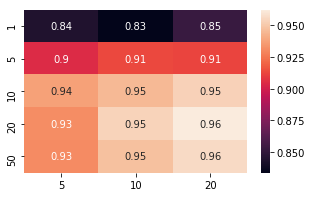

In [154]:
tr_auc, cv_auc=RF(X_train_ov, y_train_ov, X_cv_ov, y_cv_ov)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

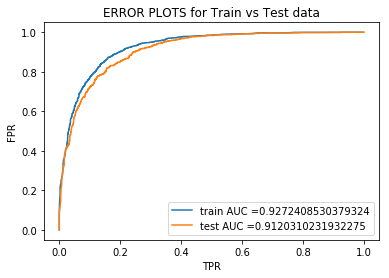

Train confusion matrix
[[1860  373]
 [ 280 1975]]
Test confusion matrix
[[1079  279]
 [ 200 1190]]


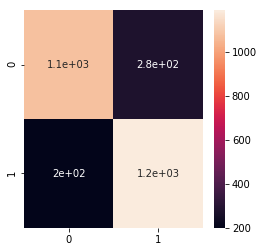

In [155]:
dep=5
n=20
cf_rf_sm,auc_rf_sm=test_RandomForest(X_train_ov, y_train_ov, X_test_ov, y_test_ov,dep,n)

### ADASYN

In [128]:
X=data3[['gender', 'attr_o', 'sinc_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc','amb', 'shar', 'prob']]
y=data3['match']
X,y=adasamp(X,y)
X_1, X_test_ov, y_1, y_test_ov = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_ov, X_cv_ov, y_train_ov, y_cv_ov = train_test_split(X_1, y_1, test_size=0.3)

Percent difference between the number of datapoints in  two samples in the given dataset:  64.71857579572018
Percent difference between the number of datapoints in two samples after ADASYN Resampling:  0.08741258741258741


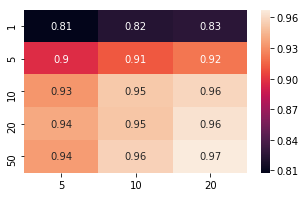

In [129]:
tr_auc, cv_auc=RF(X_train_ov, y_train_ov, X_cv_ov, y_cv_ov)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

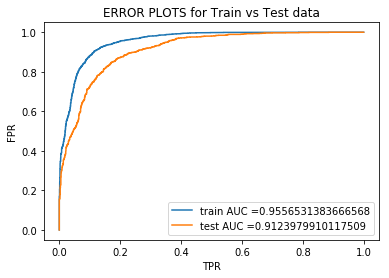

Train confusion matrix
[[1949  285]
 [ 191 2059]]
Test confusion matrix
[[1117  255]
 [ 195 1179]]


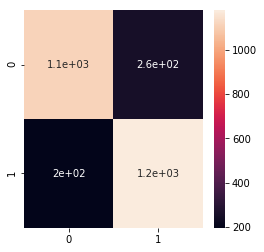

In [139]:
dep=7
n=20
cf_rf,auc_rf=test_RandomForest(X_train_ov, y_train_ov, X_test_ov, y_test_ov,dep,n)

In [156]:
X=data3[['iid','gender','age_o','int_corr','samerace','date','attr3_1','sinc3_1','fun3_1','intel3_1','amb3_1','attr','sinc','intel','fun','amb','shar','attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1','pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha']]
y=data3['match']
X,y=adasamp(X,y)
X_1, X_test_ov, y_1, y_test_ov = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_ov, X_cv_ov, y_train_ov, y_cv_ov = train_test_split(X_1, y_1, test_size=0.3)

Percent difference between the number of datapoints in  two samples in the given dataset:  64.71857579572018
Percent difference between the number of datapoints in two samples after ADASYN Resampling:  -0.5860646841762536


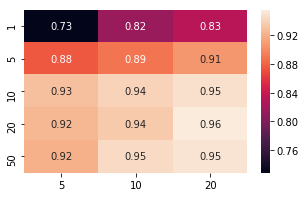

In [157]:
tr_auc, cv_auc=RF(X_train_ov, y_train_ov, X_cv_ov, y_cv_ov)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

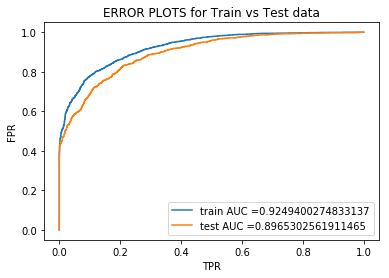

Train confusion matrix
[[1777  473]
 [ 298 1966]]
Test confusion matrix
[[1021  323]
 [ 224 1197]]


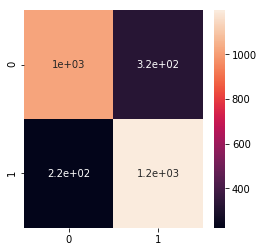

In [158]:
dep=5
n=20
cf_rf_diff,auc_rf_diff=test_RandomForest(X_train_ov, y_train_ov, X_test_ov, y_test_ov,dep,n)

### Best Results-
Features= 'gender', 'attr_o', 'sinc_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc','amb', 'shar', 'prob'

Oversampling- ADASYN

## Other Models-

### Support Vector Machine (SVM)

In [136]:
X=data3[['gender', 'attr_o', 'sinc_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc','amb', 'shar', 'prob']]
y=data3['match']
X,y=adasamp(X,y)
X_1, X_test_ov, y_1, y_test_ov = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_ov, X_cv_ov, y_train_ov, y_cv_ov = train_test_split(X_1, y_1, test_size=0.3)

Percent difference between the number of datapoints in  two samples in the given dataset:  64.71857579572018
Percent difference between the number of datapoints in two samples after ADASYN Resampling:  0.08741258741258741


1. c=0.01,g=0.01 running...
2. c=0.1,g=0.01 running...
3. c=1.0,g=0.01 running...
4. c=10.0,g=0.01 running...
5. c=0.01,g=0.1 running...
6. c=0.1,g=0.1 running...
7. c=1.0,g=0.1 running...
8. c=10.0,g=0.1 running...
9. c=0.01,g=1.0 running...
10. c=0.1,g=1.0 running...
11. c=1.0,g=1.0 running...
12. c=10.0,g=1.0 running...
13. c=0.01,g=10.0 running...
14. c=0.1,g=10.0 running...
15. c=1.0,g=10.0 running...
16. c=10.0,g=10.0 running...


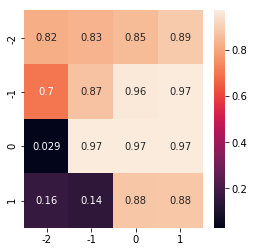

In [137]:
tr_auc, cv_auc=svc_train(X_train_ov, y_train_ov, X_cv_ov, y_cv_ov)
plot_name='SVM'
cv_auc=np.asarray(cv_auc).reshape(16,1)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(4,4)
plot_heatmap1(tr_auc, cv_auc)

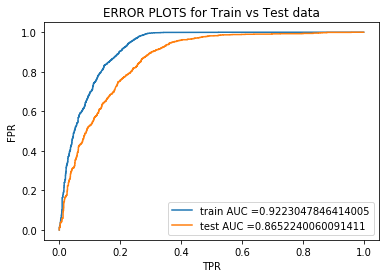

Train confusion matrix
[[2088  146]
 [ 944 1306]]
Test confusion matrix
[[1247  125]
 [ 675  699]]


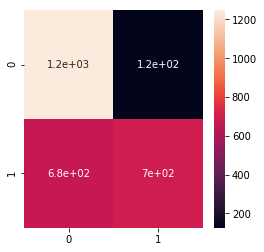

In [142]:
c=0.1
gam=0.1
cf_svm,svm_auc=test_rbf(X_train_ov, y_train_ov, X_test_ov, y_test_ov,c,gam)

## XG Boost

In [165]:
X=data3[['gender', 'attr_o', 'sinc_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc','amb', 'shar', 'prob']]
y=data3['match']
X,y=smote(X,y)
X_1, X_test_ov, y_1, y_test_ov = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_ov, X_cv_ov, y_train_ov, y_cv_ov = train_test_split(X_1, y_1, test_size=0.3)

Percent difference between the number of datapoints in  two samples in the given dataset:  64.71857579572018
Percent difference between the number of datapoints in two samples after SMOTE Resampling:  0.0


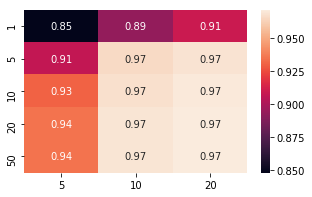

In [166]:
tr_auc, cv_auc=xgb_train(X_train_ov, y_train_ov, X_cv_ov, y_cv_ov)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

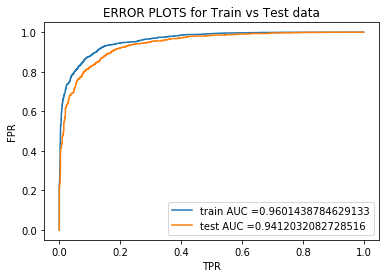

Train confusion matrix
[[2014  236]
 [ 262 1976]]
Test confusion matrix
[[1170  188]
 [ 182 1208]]


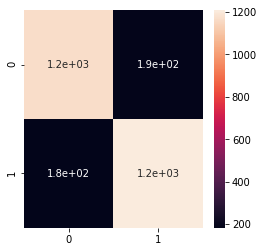

In [167]:
dep=5
n=20
cf_xgb,auc_xgb=test_xgb(X_train_ov, y_train_ov, X_test_ov, y_test_ov,dep,n)

In [174]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Feature Engineering and feature selection?","Oversampling?","Test AUC"]
x.add_row(["RF" ,"No","No", auc_rf_base])
x.add_row(["RF" , "Yes","No",auc_rf_fe])
x.add_row(["RF" ,"Yes -different features","No",auc_rf_new])
x.add_row(["RF" , "Yes","SMOTE",auc_rf_sm])
x.add_row(["RF" , "Yes","ADASYN",auc_rf])
x.add_row(["RF" , "Yes-different features","ADASYN",auc_rf_diff])
x.add_row(["SVM" ,"Yes","ADASYN",svm_auc])
x.add_row(["XGB" ,"Yes","ADASYN",auc_xgb])
print(x)

+-------+--------------------------------------------+---------------+--------------------+
| Model | Feature Engineering and feature selection? | Oversampling? |      Test AUC      |
+-------+--------------------------------------------+---------------+--------------------+
|   RF  |                     No                     |       No      | 0.8600627083547501 |
|   RF  |                    Yes                     |       No      | 0.8463473974319435 |
|   RF  |          Yes -different features           |       No      | 0.7765424430641822 |
|   RF  |                    Yes                     |     SMOTE     | 0.9120310231932275 |
|   RF  |                    Yes                     |     ADASYN    | 0.9345723473419312 |
|   RF  |           Yes-different features           |     ADASYN    | 0.8965302561911465 |
|  SVM  |                    Yes                     |     ADASYN    | 0.8652240060091411 |
|  XGB  |                    Yes                     |     ADASYN    | 0.9412032